# "Write code for people, not comupters"

In [2]:
! pip install PyYAML

In [3]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt

In [4]:
simYears = 30
thisYear = 2021
startYear = 2021

## Plan

### Here are the steps you need to complete to make this function:
-  [x] open the .yaml file with tree properties
    - [x] use these tree properties to assign a death year for each tree based on (1) species and (2) age/year planted
    
- [x] develop the architecture of the .yaml file with strategies. What will this look like? What information will it hold? How flexible/rigid will it be (at first)?

- [x] first off, based on the initial data, determine the death year of all of the trees. append this to a column 'death year' in the new dataframe

- [x]  start by making a function that simply creates the new event dataframe assuming no strategies are implemented. I.e. all the rows will have status of either "plant" or "replant." End year is determined by the death year, and replant is simply determined by the death year + 1.

- [ ]  add to that function the ability to add pruning, so the status will now be "plant," "replant," or "prune"
    * pruning will have to be implemented with some sort of year crieteria (in what year, or even better, at what age, should farmers prune?)
    * with the new row that represents the pruning event, death year carries over but is altered slightly (because we are working under the assumption that pruning increases production life)
    * unless another event is called, end year is death year
    
-  [ ] add to that function the ability to add intercropping.
    * intercropping will be implemented with (1) a year criteria and (2) a proportion criteria (what proportion of the trees will be replanted). 
    * if the trees in the originaal dataset reach the year or age criteria, the original row will become inactive because the 'end year' has been reached. The row will then be split into two rows (but both still show the same ID number, which is how we identify them as the same plot). The first row will be the trees that were left alone, and so it will be the exact same except that is has proportionally less cuerdas (the death year will carry over from the original). The second row will have the trees which were replanted. Their


In [5]:
def openYaml(yamlFilePath : str) -> dict: 
    yamlFile = open(yamlFilePath)
    parsed = yaml.load(yamlFile, Loader=yaml.SafeLoader)
    return(parsed)

In [6]:
# open the yaml files  to assign attirbutes to the sim
treeAttributes = openYaml("data/trees.yml")
strategyAttributes = openYaml("intervention/strategy.yml")

In [7]:
treeAttributes

{'borbon': {'treeType': 'borbon',
  'altOrth': 'borbón',
  'cuerdaHarvestCap': 200,
  'firstHarvest': {'year': 4, 'proportion': 0.2},
  'fullHarvest': {'year': 5, 'proportion': 1.0},
  'descentHarvest': {'year': 28, 'proportionDescent': 0.2},
  'death': {'year': 30}},
 'catuai': {'treeType': 'catuai',
  'altOrth': 'catuaí',
  'cuerdaHarvestCap': 125,
  'firstHarvest': {'year': 3, 'proportion': 0.2},
  'fullHarvest': {'year': 4, 'proportion': 1.0},
  'descentHarvest': {'year': 15, 'proportionDescent': 0.2},
  'death': {'year': 17}},
 'e14': {'treeType': 'e14',
  'altOrth': 'E14',
  'cuerdaHarvestCap': 125,
  'firstHarvest': {'year': 4, 'proportion': 0.2},
  'fullHarvest': {'year': 5, 'proportion': 1.0},
  'descentHarvest': {'year': 13, 'proportionDescent': 0.2},
  'death': {'year': 15}},
 'catura': {'treeType': 'catura',
  'altOrth': 'caturra',
  'cuerdaHarvestCap': 125,
  'firstHarvest': {'year': 3, 'proportion': 0.2},
  'fullHarvest': {'year': 4, 'proportion': 1.0},
  'descentHarvest'

In [8]:
strategyAttributes

{'replant': {'isReplant': True, 'year': 1},
 'prune': {'isPrune': True, 'age': 8, 'proportion': 1.0, 'lifeExtend': 0.15},
 'intercrop': {'isIntercrop': False, 'age': 8, 'year': 8, 'proportion': 0.1}}

In [12]:
# initialData = pd.read_csv("data/demoData.csv")
upData = pd.read_csv("data/fakeData.csv")
upData.head(5)

,plotID,farmerName,treeType,numCuerdas,yearPlanted,ageOfTrees,productionProportion
0,0,Lic. Catalina Arce,catuai,0,2016,4,0.899700
1,1,Dr. Francisca Molina,borbon,3,2015,5,0.700959
2,2,Gilberto Leonel Márquez Vásquez,catuai,4,2014,6,0.969423
3,3,Eloisa Aldonza Lozada,borbon,3,2020,0,0.967980
4,4,Elsa Emilia Barrera Bahena,catuai,3,2013,7,0.871434


In [14]:
upData[0:5].to_dict()

{'plotID': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
 'farmerName': {0: 'Lic. Catalina Arce',
  1: 'Dr. Francisca Molina',
  2: 'Gilberto Leonel Márquez Vásquez',
  3: 'Eloisa Aldonza Lozada',
  4: 'Elsa Emilia Barrera Bahena'},
 'treeType': {0: 'catuai', 1: 'borbon', 2: 'catuai', 3: 'borbon', 4: 'catuai'},
 'numCuerdas': {0: 0, 1: 3, 2: 4, 3: 3, 4: 3},
 'yearPlanted': {0: 2016, 1: 2015, 2: 2014, 3: 2020, 4: 2013},
 'ageOfTrees': {0: 4, 1: 5, 2: 6, 3: 0, 4: 7},
 'productionProportion': {0: 0.8996996684472147,
  1: 0.7009590822077385,
  2: 0.969423229738804,
  3: 0.967979682281386,
  4: 0.871433707934542}}

In [9]:
# yearPlanted = 2020 - initialData['ageOfTrees']
# initialData['yearPlanted'] = yearPlanted
# print(initialData.keys())
# new = initialData.rename(columns={'Unnamed: 0': 'plotID'})
# new.to_csv("data/demoDataUpdated.csv",  index = False)

In [10]:
def isolateAttributes(attributes:dict, treeType:str):
    """
    Takes in a dictionary containing all of the tree attributes, as well as the name of
    the tree type, then returns a dictionary with only the attributes of the tree
    `treeType`.
    """
    
    keys = list(treeAttributes.keys())
    altOrth = [treeAttributes[key]['altOrth'] for key in treeAttributes]
    # tipos = keys + altOrth # all of the possible spellings for the tree types

    if treeType in keys:
        treeDict = treeAttributes[treeType]

    elif treeType in altOrth:
        keyPair = [(key, treeAttributes[key]['altOrth']) for key in treeAttributes]
        _treeType = ''
        for i,e in enumerate(keyPair):
            if treeType == e[1]: # if it's the altOrth
                _treeType = e[0] # key to the key


            if len(_treeType) > 0:
                treeDict = treeAttributes[_treeType]
                
            else:
                raise AttributeError(
                """
                '%s' is not a recognized value (orthography) in the `treeAttributes` dict.
                
                """%(treeType))
                
    else:
        raise AttributeError(
        """
        '%s' is not a recognized value (orthography) in the `treeAttributes` dict.
                
        """%(treeType))

    return(treeDict)

In [11]:
def transformData(year:int,
                  simulationYears:int,
                  farmData:pd.DataFrame,
                  treeAttributes:dict=None,
                  strategyAttributes:dict=None):
    """
    takes in data from repository and returns a new,  transformed dataframe that
    tracks events.
    
    year is an int of the  year where the simulation starts.  if the simulation moves forward
    from  the present, the year is the current year. else it is  the  year the simulation
    begins.
    
    simulationYears is the amount of years that the simulation will iterate through. This
    is necessary to make sure the transformed data only captures events within this range. 
    
    farm data is data frame with farmer's plots
    
    tree attributes is dictionary opened from yaml file with attritbutes of trees.
    
    strategy attributes is dictionary opened from yaml file with attributes of strategies.
    
    returns dataframe with events
    
    
    Notes
    -----
    
    as of now, the condition is that intercrop year and prune year are not in the same. but I might be able to figure out how to work that out. 
    """
    
    endYear = year + simulationYears
    
    # iterate through each row of the original plot dataframe
    for i in range(len(farmData)):
        plotID = farmData["plotID"][i]
        farmerName = farmData["farmerName"][i]
        treeType = farmData["treeType"][i]
        numCuerdas =  farmData["numCuerdas"][i]
        startYear = farmData["yearPlanted"][i]
        productionProportion = farmData["productionProportion"][i]
        
        # assume all are planted for initialization
        status = "plant" 

        treeAge = year - startYear

        # check to see that this tree exists in config file
        # _altOrth = [treeAttributes[item]["altOrth"] for item in treeAttributes]
        
        if treeAttributes:
            # isolate the dictionary we are concerned with on this plot
            treeDict = isolateAttributes(attributes=treeAttributes, treeType=treeType)

            # isolate individual variables from this dict
            cuerdaHarvestCap  = treeDict["cuerdaHarvestCap"]
            firstHarvest = treeDict["firstHarvest"]
            fullHarvest = treeDict["fullHarvest"]
            descentHarvest = treeDict["descentHarvest"]
            death = treeDict["death"]

            # calculate death year
            yearsTillDeath = death["year"] - treeAge
            deathYear = year + yearsTillDeath

            # create the initial row for the transformed dataframe
            row = pd.DataFrame([[plotID, farmerName, treeType, numCuerdas, status, 
                                      startYear, deathYear, productionProportion]], columns=["plotID", "farmerName", "treeType", 
                                                "numCuerdas", "status", "startYear",
                                               "deathYear", "productionProportion"])
           
            # if this is the first row of the whole transformation
            if (i == 0):
                # initialize the transformation dataframe
                transformedData = row

            else:
                transformedData = pd.concat([transformedData, row], ignore_index=True)
                #transformedData  = transformedData.reset_index(drop = True, inplace = True)
                
                
            # now you've transformed all of the original entries to the new format
            # now you should be iterating through transformed data to add events

            # check to see if replant is in strategy (it always should be)
            if strategyAttributes["replant"]["isReplant"] ==  True:
                replantYear = (deathYear + 1)
            else:
                replantYear = None

            # check to see if prune  is in strategy config
            if strategyAttributes["prune"]["isPrune"] ==  True:
                pruneAge = strategyAttributes["prune"]["age"]
                lifeExtend = strategyAttributes["prune"]["lifeExtend"]
            else:
                pruneAge = None

            # check to see if  intercrop is in strategy config
            if strategyAttributes["intercrop"] == True:
                intercropAge = strategyAttributes["prune"]["age"]
            else:
                intercropAge = None

            # for this specific plot (see plotID),
            # create a row to check against to see if the program needs to continue creating events
            checkRow = row

            # create a  new var for the year of transformation for this plot
            simYear = year
            # create a new var for the tree's age for this plot
            simTreeAge = treeAge

            # iterate through all years of the simulation to check event sequences
            while (simYear < endYear):
               #  isolate dict
                deathYear = checkRow["deathYear"][0]


                if (replantYear):
                    # death takes precedence over pruning 
                    if (simYear == deathYear):
                        # update death year
                        simTreeAge = -1
                        deathYear = (simYear +  1) + death["year"]
                        status = "replant"
                        nextRow = pd.DataFrame([[plotID, farmerName, treeType, numCuerdas, status, replantYear, deathYear,productionProportion]], 
                                            columns=["plotID", "farmerName","treeType", "numCuerdas", "status", "startYear","deathYear","productionProportion"])
                        transformedData  = pd.concat([transformedData, nextRow],  ignore_index=True)
                        checkRow = nextRow
                        simYear += 1
                        simTreeAge += 1
                        
                        # no more than one action per year IF action is death
                        continue


                    elif (pruneAge):
                        if (simTreeAge == pruneAge):
                            # add years proportional to tree's lifespan:
                            addedYears = round((death["year"] * lifeExtend))
                            adjustedDeathYear = (checkRow["deathYear"][0]) + addedYears
                            pruneYear = simYear
                            status = "prune"
                            nextRow = pd.DataFrame([[plotID, farmerName,treeType, numCuerdas, status, pruneYear, adjustedDeathYear, productionProportion]], 
                                                   columns=["plotID", "farmerName","treeType", "numCuerdas", "status", "startYear","deathYear","productionProportion"])
                            transformedData  = pd.concat([transformedData, nextRow],  ignore_index=True)
                            checkRow  = nextRow
                            simYear += 1
                            simTreeAge += 1
                            continue

                        else:
                            simYear += 1
                            simTreeAge += 1
                            continue
                            
                    else:
                        simYear += 1
                        simTreeAge += 1
                        continue

                else:
                    simYear += 1
                    simTreeAge += 1
                    continue



        else:
            print("No tree attributes!!!")
            print(treeType)
            break
            
        
    return(transformedData)

Right now productionProportion column is not functioning in relationship to events

In [12]:
simData = transformData(year=startYear, simulationYears=simYears, farmData=upData,
                        treeAttributes=treeAttributes, strategyAttributes=strategyAttributes)
simData[30:40]

,plotID,farmerName,treeType,numCuerdas,status,startYear,deathYear,productionProportion
30,8,Timoteo Quiñónez Miramontes,catuai,6,prune,2024,2036,0.716944
31,8,Timoteo Quiñónez Miramontes,catuai,6,replant,2034,2054,0.716944
32,8,Timoteo Quiñónez Miramontes,catuai,6,prune,2045,2057,0.716944
33,9,Pascual Rafaél Villareal Botello,borbon,9,plant,1992,2022,0.849839
34,9,Pascual Rafaél Villareal Botello,borbon,9,replant,2023,2053,0.849839
35,9,Pascual Rafaél Villareal Botello,borbon,9,prune,2031,2057,0.849839
36,10,Jerónimo Aponte,catuai,7,plant,2019,2036,0.829217
37,10,Jerónimo Aponte,catuai,7,prune,2027,2039,0.829217
38,10,Jerónimo Aponte,catuai,7,replant,2037,2057,0.829217
39,10,Jerónimo Aponte,catuai,7,prune,2048,2060,0.829217


In [13]:
simData.reset_index(inplace = True)
simData = simData.rename(columns = {'index':'event'})

In [14]:
simData

,event,plotID,farmerName,treeType,numCuerdas,status,startYear,deathYear,productionProportion
0,0,0,Emilio Manzanares Garibay,catuai,7,plant,2018,2035,0.970648
1,1,0,Emilio Manzanares Garibay,catuai,7,prune,2026,2038,0.970648
2,2,0,Emilio Manzanares Garibay,catuai,7,replant,2036,2056,0.970648
3,3,0,Emilio Manzanares Garibay,catuai,7,prune,2047,2059,0.970648
4,4,1,Hernán Jaramillo Camacho,borbon,5,plant,2012,2042,0.720967
...,...,...,...,...,...,...,...,...,...
336,336,98,Amador Amador Feliciano Ortiz,borbon,4,prune,2042,2068,0.881308
337,337,99,Ing. Ivonne Alcaraz,catuai,7,plant,2016,2033,0.777647
338,338,99,Ing. Ivonne Alcaraz,catuai,7,prune,2024,2036,0.777647
339,339,99,Ing. Ivonne Alcaraz,catuai,7,replant,2034,2054,0.777647


In [15]:
import dataclasses

In [16]:
treeAttributes

{'borbon': {'treeType': 'borbon',
  'altOrth': 'borbón',
  'cuerdaHarvestCap': 200,
  'firstHarvest': {'year': 4, 'proportion': 0.2},
  'fullHarvest': {'year': 5, 'proportion': 1.0},
  'descentHarvest': {'year': 28, 'proportionDescent': 0.2},
  'death': {'year': 30}},
 'catuai': {'treeType': 'catuai',
  'altOrth': 'catuaí',
  'cuerdaHarvestCap': 125,
  'firstHarvest': {'year': 3, 'proportion': 0.2},
  'fullHarvest': {'year': 4, 'proportion': 1.0},
  'descentHarvest': {'year': 15, 'proportionDescent': 0.2},
  'death': {'year': 17}},
 'e14': {'treeType': 'e14',
  'altOrth': 'E14',
  'cuerdaHarvestCap': 125,
  'firstHarvest': {'year': 4, 'proportion': 0.2},
  'fullHarvest': {'year': 5, 'proportion': 1.0},
  'descentHarvest': {'year': 13, 'proportionDescent': 0.2},
  'death': {'year': 15}},
 'catura': {'treeType': 'catura',
  'altOrth': 'caturra',
  'cuerdaHarvestCap': 125,
  'firstHarvest': {'year': 3, 'proportion': 0.2},
  'fullHarvest': {'year': 4, 'proportion': 1.0},
  'descentHarvest'

In [17]:
upData.columns

Index(['plotID', 'farmerName', 'treeType', 'numCuerdas', 'yearPlanted',
       'ageOfTrees', 'productionProportion'],
      dtype='object')

In [18]:
from datetime import datetime

datetime.fromisoformat('2021-01-01:00:10')

datetime.datetime(2021, 1, 1, 0, 10)

In [19]:
import math
math.floor(24.5)

24

In [20]:
from dataclasses import dataclass, field
from numbers import Number
import datetime
import random
import math

@dataclass
class Plot:
    num: int = 1  # crops / unit of area
    area: float = 1.0
    plot_id: int = 0
    species: str = field(default_factory=str)
    unit: str = 'cuerdas'
    origin: datetime = datetime.datetime(2020, 1, 1, 0, 0)

    def show(self) -> str:
        return self.__repr__()

    def age(self, current_time=datetime.datetime.today()) -> datetime.timedelta:
        return current_time - self.origin

    @property
    def years(self) -> int:
        return round(self.age.days/365.25)

    @property
    def days(self) -> int:
        return self.age.days

    @property
    def mins(self) -> int:
        return round(self.age.seconds/60)

    @staticmethod
    def to_datetime(time) -> datetime.datetime:
        if isinstance(time, Number):  # assumes `time` = year
            return datetime.datetime(round(time), 1, 1, 0, 0)
        elif isinstance(time, datetime.datetime):
            return time
        else:
            raise ValueError(f"Please specify a valid time. Given {type(time)}")

    @classmethod
    def from_series(cls, series):
        return cls.from_density(
            density=1.0,
            plot_id=series.plotID,
            species=series.treeType,
            area=series.numCuerdas,
            unit='cuerdas',
            origin=cls.to_datetime(series.yearPlanted),
        )

    @classmethod
    def from_dict(cls, dict):
        return cls.from_series(pd.Series(dict))

    @classmethod
    def from_density(cls, density: float = 1.0, **kwargs):
        plot = cls(**kwargs)
        plot.num = math.floor(plot.area * density)
        return plot

In [21]:
Plot(0.7)

Plot(num=0.7, area=1.0, plot_id=0, species='', unit='cuerdas', origin=datetime.datetime(2020, 1, 1, 0, 0))

In [22]:
p = Plot()
p

Plot(num=1, area=1.0, plot_id=0, species='', unit='cuerdas', origin=datetime.datetime(2020, 1, 1, 0, 0))

In [23]:
Plot.from_density(2, area=2, species='ket')

Plot(num=4, area=2, plot_id=0, species='ket', unit='cuerdas', origin=datetime.datetime(2020, 1, 1, 0, 0))

In [24]:
p

Plot(num=1, area=1.0, plot_id=0, species='', unit='cuerdas', origin=datetime.datetime(2020, 1, 1, 0, 0))

In [25]:
series = upData.iloc[0]
series.to_dict()

{'plotID': 0,
 'farmerName': 'Emilio Manzanares Garibay',
 'treeType': 'catuai',
 'numCuerdas': 7,
 'yearPlanted': 2018,
 'ageOfTrees': 2,
 'productionProportion': 0.9706483571847314}

In [26]:
Plot.from_dict(series.to_dict())

Plot(num=7, area=7, plot_id=0, species='catuai', unit='cuerdas', origin=datetime.datetime(2018, 1, 1, 0, 0))

In [27]:
p = Plot(0, '', 0.1)
p

Plot(num=0, area='', plot_id=0.1, species='', unit='cuerdas', origin=datetime.datetime(2020, 1, 1, 0, 0))

In [28]:
# Plot.from_attrs('borbon', treeAttributes)

In [29]:
p = Plot.from_series(upData.iloc[0])

In [30]:
p1 = Plot.from_series(upData.iloc[1])

In [31]:
p.to_datetime(datetime.datetime(2000, 1, 1, 0, 0))

datetime.datetime(2000, 1, 1, 0, 0)

In [32]:
p1

Plot(num=5, area=5, plot_id=1, species='borbon', unit='cuerdas', origin=datetime.datetime(2012, 1, 1, 0, 0))

In [33]:
p1.age(datetime.datetime(2330, 1, 1, 0, 0))

datetime.timedelta(days=116147)

In [34]:
from dataclasses import field
from typing import List, Dict

@dataclass
class Farm:
    plot_list: List[Plot] = field(default_factory=List)

    @classmethod
    def from_csv(cls, csv_file):
        df = pd.read_csv(csv_file)
        list_of_plots = []
        for idx, series in df.iterrows():
            list_of_plots.append(Plot.from_series(series))
        return cls(list_of_plots)

    @property
    def plots(self) -> List[Plot]:
        return self.plot_list
    
    @property
    def ids(self) -> List[str]:
        return [p.plot_id for p in self.plot_list]

    def contains(self, species: str ='') -> bool:
        return species in set(p.species for p in self.plot_list)
    
    

In [35]:
farm = Farm.from_csv('data/fakeData.csv')

In [36]:
farm.plot_list[0:10]

[Plot(num=7, area=7, plot_id=0, species='catuai', unit='cuerdas', origin=datetime.datetime(2018, 1, 1, 0, 0)),
 Plot(num=5, area=5, plot_id=1, species='borbon', unit='cuerdas', origin=datetime.datetime(2012, 1, 1, 0, 0)),
 Plot(num=10, area=10, plot_id=2, species='catuai', unit='cuerdas', origin=datetime.datetime(2015, 1, 1, 0, 0)),
 Plot(num=9, area=9, plot_id=3, species='catuai', unit='cuerdas', origin=datetime.datetime(2019, 1, 1, 0, 0)),
 Plot(num=6, area=6, plot_id=4, species='borbon', unit='cuerdas', origin=datetime.datetime(2007, 1, 1, 0, 0)),
 Plot(num=8, area=8, plot_id=5, species='catura', unit='cuerdas', origin=datetime.datetime(2020, 1, 1, 0, 0)),
 Plot(num=4, area=4, plot_id=6, species='borbon', unit='cuerdas', origin=datetime.datetime(1997, 1, 1, 0, 0)),
 Plot(num=10, area=10, plot_id=7, species='catura', unit='cuerdas', origin=datetime.datetime(2006, 1, 1, 0, 0)),
 Plot(num=6, area=6, plot_id=8, species='catuai', unit='cuerdas', origin=datetime.datetime(2016, 1, 1, 0, 0)

In [37]:
p.area

7

In [38]:
config = {
    ''
}

In [39]:
#TODO: can we instantiate this fromtreeAttribs / write a conversion method?
# TODO: pint for unit registries
import attr
# @attr.s(hash=True)

#     @property
#     def get_name(self):
#         if self.name:
#             return self.name
#         return self.species

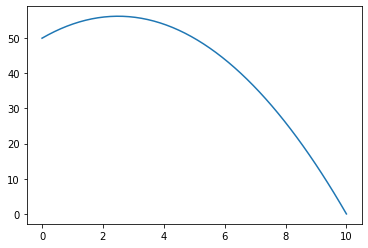

In [40]:
# TODO: David asked about density curves.
# We know that output is a function of density.
# So we need to be able to instantiate a config based on any point along this line.

# dummy curve
import numpy as np
x = np.linspace(0, 10, 50)
y = -x ** 2 + 5 * x + 50
plt.plot(x, y)

In [41]:
# TASK: Given (x, y) (or some kind of relation), return a yield

## predict yield

In [50]:
p

Plot(num=7, area=7, plot_id=0, species='catuai', unit='cuerdas', origin=datetime.datetime(2018, 1, 1, 0, 0))

In [51]:
import pytest

In [53]:
# like we loaded from a database or something...
configs = (Config('e14', 'e14-sparse'), Config('borbon', 'borbon-intercroppped'), Config('catuai', 'catuai'), Config('catura', 'catura'))

In [56]:
find_config('borbon', configs)

<ipython-input-55-5dc85b3113cf>:13: UserWarning: Could not find canonical match for species=`borbon`, searching for match against species instead.
  warnings.warn(f'Could not find canonical match for species=`{name}`, searching for match against species instead.')


Config(species='borbon', name='borbon-intercroppped', output_per_crop=1.0, unit='cuerdas')

In [58]:
farm.plots[:3]

[Plot(num=7, area=7, plot_id=0, species='catuai', unit='cuerdas', origin=datetime.datetime(2018, 1, 1, 0, 0)),
 Plot(num=5, area=5, plot_id=1, species='borbon', unit='cuerdas', origin=datetime.datetime(2012, 1, 1, 0, 0)),
 Plot(num=10, area=10, plot_id=2, species='catuai', unit='cuerdas', origin=datetime.datetime(2015, 1, 1, 0, 0))]

In [59]:
configs

(Config(species='e14', name='e14-sparse', output_per_crop=1.0, unit='cuerdas'),
 Config(species='borbon', name='borbon-intercroppped', output_per_crop=1.0, unit='cuerdas'),
 Config(species='catuai', name='catuai', output_per_crop=1.0, unit='cuerdas'),
 Config(species='catura', name='catura', output_per_crop=1.0, unit='cuerdas'))

<ipython-input-55-5dc85b3113cf>:13: UserWarning: Could not find canonical match for species=`fake`, searching for match against species instead.
  warnings.warn(f'Could not find canonical match for species=`{name}`, searching for match against species instead.')


In [63]:
# TODO: test that a bad config does not stop the simulation (i.e. we catch the ValueError thrown above)

In [64]:
find_config('e14', configs)

<ipython-input-55-5dc85b3113cf>:13: UserWarning: Could not find canonical match for species=`e14`, searching for match against species instead.
  warnings.warn(f'Could not find canonical match for species=`{name}`, searching for match against species instead.')


Config(species='e14', name='e14-sparse', output_per_crop=1.0, unit='cuerdas')

In [65]:
# test that membership checks work for species
farm.contains(species='e14')

False

In [66]:
harvest = predict_yield_for_farm(farm, configs)

<BarContainer object of 100 artists>

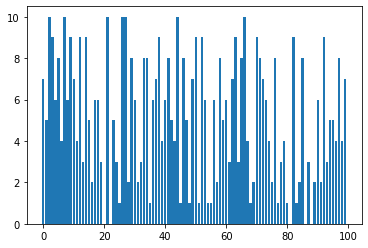

In [67]:
plt.bar(farm.ids, harvest)

---

In [68]:
class Plot:

    def __init__(self, _simYear, _plotID, _farmerName, _treeType, _cuerdas, _status, _startYear, _deathYear, _treeAttributes = treeAttributes):
        self.plotID = _plotID
        self.farmerName = _farmerName

        self.inheretTreeProperties(_treeType)

        self.totalCuerdas = _cuerdas
        
       
        self.startYear = _startYear
        self.deathYear = _deathYear
        self.setStatus(_status, _simYear) 
        
        if self.status == "plant":
            self.treeAge = self.simYear - self.startYear
            
        self.getProduction()
        # self.sowDensity = _sowDensity # sow density in trees/hectare
        # self.totalTrees = int(round((_cuerdas * _sowDensity), 0)) # round to nearest and convert to int because we can't have poritions of trees

    def inheretTreeProperties(self, treeType):
        """ 
        Based on the argument treeType in the initializer function, assign parameters for the respective
        life & production patterns of the trees on the cuerda.
        """
        self.firstHarvest = treeAttributes[treeType]['firstHarvest'] # year of first harvest and proportion of harvest until 
        self.fullHarvest = treeAttributes[treeType]['fullHarvest'] # year of first harvest and proportion of harvest
        self.descentHarvest = treeAttributes[treeType]['descentHarvest'] # year that production descends and annual proportion descent
        # self.pruneHarvest = {'yearShift': -5, 'proportionAscent': 0.2} # these are placeholder values to remember to add member val

        self.cuerdaHarvestCap = treeAttributes[treeType]['cuerdaHarvestCap']
        self.treeType = treeType
        self.death = treeAttributes[treeType]['death']
        loop = False

    def updateEvent(self, _simYear, _status, _startYear, _deathYear):
        self.startYear = _startYear
        self.deathYear = _deathYear
        self.setStatus(_status, _simYear)
        
        
    def setStatus(self, _status, _simYear):
        self.status = _status
        self.simYear = _simYear
            
        if (self.status == "plant") or (self.status == "replant"):
            self.treeAge = self.simYear - self.startYear
            # if the trees are in their first production year(s)
            if (self.treeAge <= self.firstHarvest['year']) and (self.treeAge < self.fullHarvest['year']):
                self.prodProportion = self.firstHarvest['proportion']
                
            # if the trees are in their full production years
            elif (self.treeAge >= self.fullHarvest['year']) and (self.treeAge < self.descentHarvest['year']):
                    self.prodProportion = self.fullHarvest['proportion']
                    
            # if the trees are in their descending production year(s)
            elif (self.treeAge >= self.descentHarvest['year']):
                self.prodProportion = self.descentHarvest['proportionDescent']
            
        if (self.status == "prune"):
            if (self.simYear - self.startYear) == 1:
                self.prodProportion = .5                    
            elif (self.simYear - self.startYear) == 2:
                self.prodProportion = .75
                    
            else:
                self.prodProportion = 1
                
        self.getProduction()


                    
    def getProduction(self):
        self.production = self.totalCuerdas * self.cuerdaHarvestCap * self.prodProportion

    def getRow(self):
        data = {"plotID": self.plotID,
                "simulationYear": self.simYear,
                "farmerName": self.farmerName,
                "treeType": self.treeType,
                "cuerdas": self.totalCuerdas,
                "treeAge": self.treeAge,
                "status": self.status,
                "harvestCap": self.cuerdaHarvestCap,
                "harvestProportion": self.prodProportion,
                "harvest": self.production}
            
        self.row = pd.DataFrame(data, index=[self.simYear])
        
        return(self.row)


In [69]:
def getEvent(year, plotDf, bottomLimit = "startYear"):
    """
    Uses the argument 'year' passed to figure out which event is currently in progress
    for a specific plot. Returns the event number for that plot.
    """
    
    
    # sort the dataframe of this plot in descending order by event start year
    plotDf = plotDf.sort_values(by=[bottomLimit], ascending = False)
    
    # iterate through rows in reverse chronological
    for i,row in plotDf.iterrows():
        # if the current simulation year is larger or equal to the event start year
        if year >= row["startYear"]:
            eventNumber = i
            break
    
    return(eventNumber)

In [70]:
def initClass(year, eventData, eventNumber, treeAttributes):
    plotID = int(eventData['plotID'][eventNumber])
    farmerName = str(eventData['farmerName'][eventNumber])
    treeType = str(eventData['treeType'][eventNumber])
    cuerdas = float(eventData['numCuerdas'][eventNumber])
    status = str(eventData['status'][eventNumber])
    startYear = int(eventData['startYear'][eventNumber])
    deathYear = int(eventData['deathYear'][eventNumber])
    
    plot = Plot(_simYear = year, _plotID = plotID, _farmerName = farmerName, _treeType = treeType, _cuerdas = cuerdas, _status = status, _startYear = startYear, _deathYear = deathYear)
    
    return(plot)

In [71]:
def initAllPlots(simData, year = 2020, treeAttributes = treeAttributes):
    # iterate through every plot
    plots = list(simData.groupby("plotID").groups.keys())
    
    plotClasses = []
    for i, plotID in enumerate(plots):
        _plot = simData[simData["plotID"] == plotID]
        _eventNumber = getEvent(year, _plot)
        _event = _plot[_plot["event"] ==_eventNumber]
        _plotClass = initClass(year, _event, _eventNumber, treeAttributes)
        plotClasses.append(_plotClass)
        
    return(plotClasses)


In [76]:
def simulate(eventData, treeAttributes, startYear = 2020, years = 30):
    plotClasses = []
    # simulationDf = pd.DataFrame()
    currentYear = startYear
    #print(eventData)

    plotClasses = initAllPlots(simData = eventData, year = startYear, treeAttributes = treeAttributes)
    
    simulationDf = plotClasses[0].getRow()
    for plotIndex,plot in enumerate(plotClasses):
        if plotIndex == 0:
            print()
        else:
            newRow = plot.getRow()
            simulationDf = pd.concat([simulationDf, newRow])
                    
    for i in range(1,years):
        currentYear = startYear + i
        for plotIndex,plot in enumerate(plotClasses):
            _plotID = plot.plotID

            plotData = simData[simData["plotID"] == _plotID]
            eventNumber = getEvent(year=currentYear, plotDf = plotData)
            #event = eventData[eventData["event"] == eventNumber]
            eventStatus = plotData["status"][eventNumber]
            eventStartYear = plotData["startYear"][eventNumber]
            eventDeathYear = plotData["deathYear"][eventNumber]

            plot.updateEvent(_simYear = currentYear, _status = eventStatus, _startYear = eventStartYear, _deathYear = eventDeathYear)

            newRow = plot.getRow()
            simulationDf = pd.concat([simulationDf, newRow])


    return(simulationDf)

In [77]:
x = simulate(simData, treeAttributes)

In [78]:
x

,plotID,simulationYear,farmerName,treeType,cuerdas,treeAge,status,harvestCap,harvestProportion,harvest
2020,0,2020,Emilio Manzanares Garibay,catuai,7.0,2,plant,125,0.2,175.0
2020,1,2020,Hernán Jaramillo Camacho,borbon,5.0,8,plant,200,1.0,1000.0
2020,2,2020,Angélica Horacio Jaimes,catuai,10.0,5,plant,125,1.0,1250.0
2020,3,2020,Emilio Manzanares Garibay,catuai,9.0,1,plant,125,0.2,225.0
2020,4,2020,Pascual Rafaél Villareal Botello,borbon,6.0,13,plant,200,1.0,1200.0
...,...,...,...,...,...,...,...,...,...,...
2049,95,2049,María del Carmen José María Franco,borbon,5.0,7,prune,200,1.0,1000.0
2049,96,2049,Gabriela Ernesto Ruelas Tamez,borbon,4.0,7,prune,200,1.0,800.0
2049,97,2049,Diego Carranza,catuai,8.0,7,prune,125,1.0,1000.0
2049,98,2049,Amador Amador Feliciano Ortiz,borbon,4.0,7,prune,200,1.0,800.0


In [74]:
projection = x.groupby(['plotID', 'simulationYear']).sum()['harvest'].groupby('simulationYear').sum()

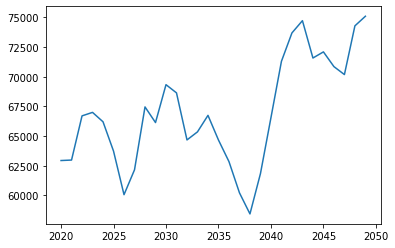

In [75]:
plt.plot(projection)

In [ ]:
allPlots = initAllPlots(simData)

In [ ]:
x = allPlots[0].getRow()

In [ ]:
x

In [ ]:
# test = plots[0]
testEventNumber = 2

In [ ]:
testEvent = simData[simData["event"] == testEventNumber]

In [ ]:
testEvent

In [ ]:
treeAttributes['catura']

In [ ]:
testPlot = initClass(2020, testEvent, testEventNumber, treeAttributes)

In [ ]:
testPlot.startYear

# To do:

- [ ] review farm class and see what's going on
- [ ] figure out how to incorporate classes into what is happening here

In [ ]:
# group by the individual ids for iteration
byID = simData.groupby("plotID")

# iterate through each plot
for plotID, group in byID:
    #print(plotID)
    
    # iterate through each event for each plot
    for eventNumber, event in group.iterrows():
        #print(event["farmerName"])
        x = 0
        

In [ ]:
def simulate(startYear:int, simultationYears:int, eventData:pd.DataFrame):
    
    for i in range(simultationYears):
        simYear = startYear + i
        
        
        

In [ ]:
round?